In [2]:
import pandas as pd

test = pd.read_csv('/Users/tyco/Desktop/MADS/sanovo_19052025/data/processed/data_snapshots.csv')
test['lane_stopping_machine'] = test.apply(lambda row: row['MerSubNumber'] if row['MerNumber'] >= 400 else row['lane_stopping_machine'], axis=1)
test.head(5)

,index,MerDate,MerId,MerType,MerNumber,MerSubNumber,MerData1,MerData2,MerData3,MerData4,MerData5,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority,Error/warnings,lane_stopping_machine,snapshot,time_delta
0,0,2025-01-30 10:21:42,11897186,21,460,12,1.0,22.0,41.0,NaN,NaN,4620,NaN,0,0,0,21_460_22.0_41.0,12.0,1,0 days 00:04:02
1,1,2025-01-30 10:21:56,11897187,23,460,12,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,23_460_0.0_0.0,12.0,1,0 days 00:04:02
2,2,2025-01-30 10:21:56,11897188,21,460,12,1.0,22.0,41.0,NaN,NaN,4620,NaN,0,0,0,21_460_22.0_41.0,12.0,1,0 days 00:04:02
3,3,2025-01-30 10:21:57,11897189,23,460,12,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,23_460_0.0_0.0,12.0,1,0 days 00:04:02
4,4,2025-01-30 10:21:57,11897190,21,460,12,1.0,22.0,41.0,NaN,NaN,4620,NaN,0,0,0,21_460_22.0_41.0,12.0,1,0 days 00:04:02


In [3]:
test['lane_stopping_machine'].unique()

array([12., nan,  7., 16.,  4.,  8., 10., 17.,  0., 14.,  9., 13., 11.,
       15.,  3., 18.,  5.,  6.,  2.,  1.])

# We need to following columns for a new experiment

- number of cumulative errors during window
- number of cumulative warnings during window
- sum per error type during window
- time per seconds during window
- time without date
- sum per warning type during window 
- classification of the model in 5 parts: start, stop, normal, ascending stop/jam, decreasing stop/jam

# Steps to take
- we want to make the columns correct per window
- we want to label the data according to the classification parts

Column fixing

In [4]:
selected_columns = test[['MerType', 'MerDate', 'MerNumber', 'MerSubNumber','snapshot', 'lane_stopping_machine']] 
selected_columns['is_error'] = (selected_columns['MerType'] == 21).astype(int)
selected_columns['is_warning'] = (selected_columns['MerType'] == 22).astype(int)
selected_columns['is_solved'] = (selected_columns['MerType'] == 23).astype(int)
selected_columns['is_lowered'] = (selected_columns['MerType'] == 24).astype(int)
selected_columns['stop'] = selected_columns.apply(lambda row: row['MerSubNumber'] if row['MerType'] == 8 and row['MerSubNumber'] == 2 else 1, axis=1)

selected_columns.head()

/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_53791/3352207782.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns['is_error'] = (selected_columns['MerType'] == 21).astype(int)
/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_53791/3352207782.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns['is_warning'] = (selected_columns['MerType'] == 22).astype(int)
/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_53791/3352207782.py:4: SettingWithCop

,MerType,MerDate,MerNumber,MerSubNumber,snapshot,lane_stopping_machine,is_error,is_warning,is_solved,is_lowered,stop
0,21,2025-01-30 10:21:42,460,12,1,12.0,1,0,0,0,1
1,23,2025-01-30 10:21:56,460,12,1,12.0,0,0,1,0,1
2,21,2025-01-30 10:21:56,460,12,1,12.0,1,0,0,0,1
3,23,2025-01-30 10:21:57,460,12,1,12.0,0,0,1,0,1
4,21,2025-01-30 10:21:57,460,12,1,12.0,1,0,0,0,1


In [5]:
# Concatenating the one-hot encoded columns with the original dataframe
onehot_encoded_mernumber = pd.get_dummies(selected_columns['MerNumber'], prefix='MerNumber').astype(int)
test_with_onehot = pd.concat([selected_columns, onehot_encoded_mernumber], axis=1)

onehot_selected = test_with_onehot.drop(columns=['MerType', 'MerNumber'])
onehot_selected.head()


,MerDate,MerSubNumber,snapshot,lane_stopping_machine,is_error,is_warning,is_solved,is_lowered,stop,MerNumber_0,...,MerNumber_458,MerNumber_460,MerNumber_461,MerNumber_462,MerNumber_470,MerNumber_480,MerNumber_481,MerNumber_483,MerNumber_490,MerNumber_511
0,2025-01-30 10:21:42,12,1,12.0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,2025-01-30 10:21:56,12,1,12.0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,2025-01-30 10:21:56,12,1,12.0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,2025-01-30 10:21:57,12,1,12.0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,2025-01-30 10:21:57,12,1,12.0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [6]:
onehot_selected['is_error_cumulative'] = onehot_selected['is_error'].cumsum()
onehot_selected['is_warning_cumulative'] = onehot_selected['is_warning'].cumsum()
onehot_selected['MerDate'] = onehot_selected['MerDate'].astype('datetime64[s]')
onehot_selected['time'] = onehot_selected['MerDate'].dt.time
onehot_selected['time'] = onehot_selected['time'].astype(str)

onehot_selected.head()

,MerDate,MerSubNumber,snapshot,lane_stopping_machine,is_error,is_warning,is_solved,is_lowered,stop,MerNumber_0,...,MerNumber_462,MerNumber_470,MerNumber_480,MerNumber_481,MerNumber_483,MerNumber_490,MerNumber_511,is_error_cumulative,is_warning_cumulative,time
0,2025-01-30 10:21:42,12,1,12.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,10:21:42
1,2025-01-30 10:21:56,12,1,12.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,10:21:56
2,2025-01-30 10:21:56,12,1,12.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,2,0,10:21:56
3,2025-01-30 10:21:57,12,1,12.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,2,0,10:21:57
4,2025-01-30 10:21:57,12,1,12.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,3,0,10:21:57


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

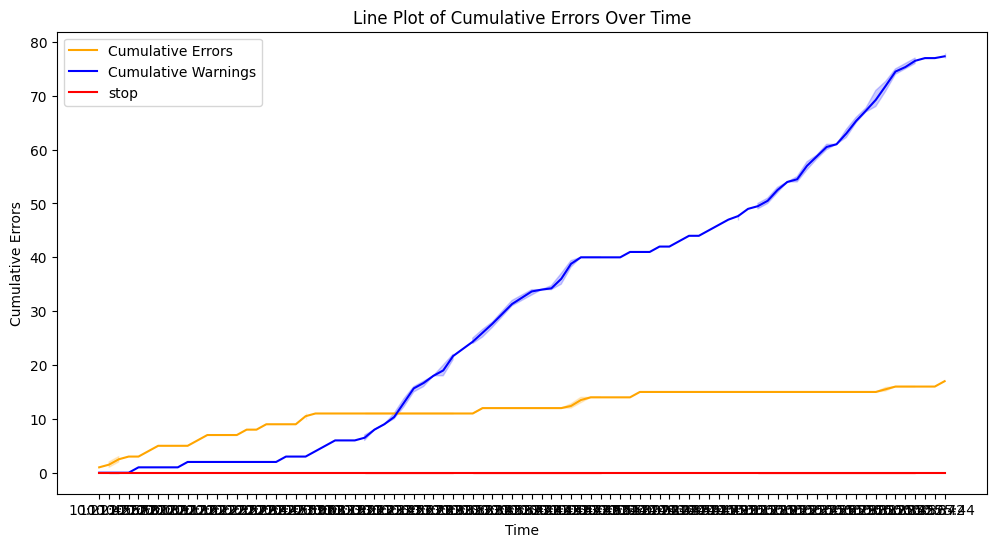

In [61]:
df = onehot_selected[onehot_selected['snapshot'] == 1]


plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='time', y='is_error_cumulative', label='Cumulative Errors', color='orange')
sns.lineplot(data=df, x='time', y='is_warning_cumulative', label='Cumulative Warnings', color='blue')
sns.lineplot(data=df, x='time', y='stop', label='stop', color='red')

plt.title('Line Plot of Cumulative Errors Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Errors')
plt.legend()
plt.show()

In [ ]:
# Aggregating columns per snapshot
aggregated_data = onehot_selected.groupby('snapshot').agg({
    'is_error': 'sum',
    'is_warning': 'sum',
    'is_solved': 'sum',
    'is_lowered': 'sum',
    'MerDate': 'count'
}).rename(columns={'is_error': 'total_errors', 'is_warning': 'total_warnings', 'MerDate': 'total_events'}).reset_index()

aggregated_data = aggregated_data[aggregated_data['total_events'] > 1000]

In [28]:
print(aggregated_data['snapshot'].max())

24805


In [48]:

def plot_this(df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='snapshot', y='total_errors', label='Total Errors', color='red')
    sns.lineplot(data=df, x='snapshot', y='total_warnings', label='Total Warnings', color='orange')
    sns.lineplot(data=df, x='snapshot', y='is_solved', label='Total Solved', color='blue')
    sns.lineplot(data=df, x='snapshot', y='total_events', label='Total Events', color='green')


    plt.title('Line Plot of Total Errors and Warnings by Snapshot')
    plt.xlabel('Snapshot')
    plt.ylabel('Count')
    plt.legend()
    plt.show()


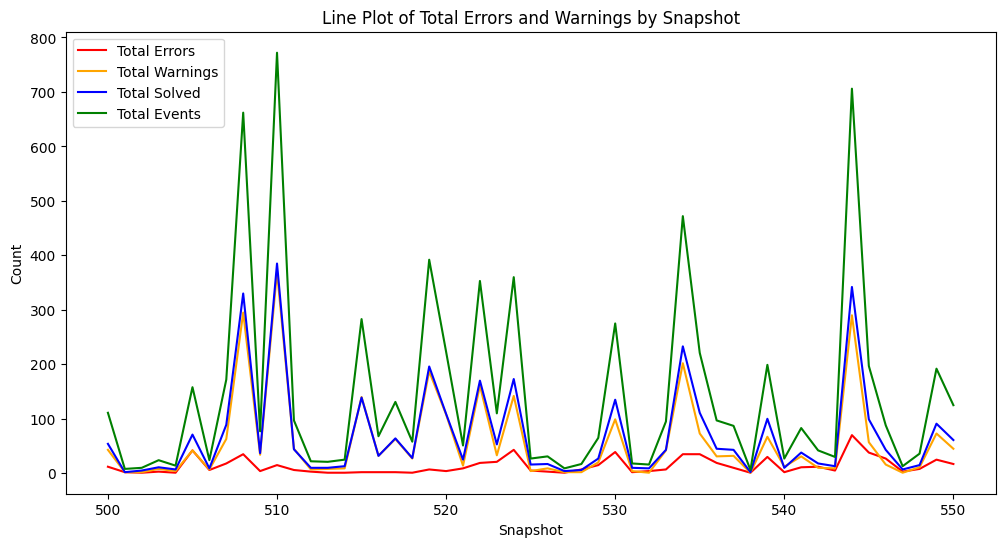

In [68]:
filtered_data = aggregated_data[(aggregated_data['snapshot'] >= 500)&(aggregated_data['snapshot'] <= 550)]

plot_this(filtered_data)

# We want snapshots in the following fases: start, stop, normal, ascending stop/jam, decreasing stop/jam

at index 184 there is a stop and at 188 a start. At index 372 there is a stop and at 377 a start.

In [57]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
import pandas as pd

data = pd.read_csv('/Users/tyco/Desktop/MADS/sanovo/data/raw/HSTMachineError.csv')
full_df = data.iloc[1:377]
# full_df = data.iloc[1:1000]


In [85]:
full_df['is_error'] = (full_df['MerType'] == 21).astype(int)
full_df['is_warning'] = (full_df['MerType'] == 22).astype(int)
full_df['is_solved'] = (full_df['MerType'] == 23).astype(int)
full_df['is_lowered'] = (full_df['MerType'] == 24).astype(int)
full_df['stop'] = full_df.apply(lambda row: row['MerNumber'] * 100 if row['MerType'] == 8  else 100, axis=1)
full_df['is_error_cumulative'] = full_df['is_error'].cumsum()
full_df['is_warning_cumulative'] = full_df['is_warning'].cumsum()

full_df = full_df[['MerDate', 'MerNumber', 'MerSubNumber','is_error','is_error_cumulative','is_warning','is_warning_cumulative','is_solved','is_lowered','stop']] 
full_df.head()

/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_34270/3429815386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['is_error'] = (full_df['MerType'] == 21).astype(int)
/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_34270/3429815386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['is_warning'] = (full_df['MerType'] == 22).astype(int)
/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_34270/3429815386.py:3: SettingWithCopyWarning: 
A value is trying to be s

,MerDate,MerNumber,MerSubNumber,is_error,is_error_cumulative,is_warning,is_warning_cumulative,is_solved,is_lowered,stop
1,2025-01-30 10:21:42.000,460,12,1,1,0,0,0,0,100
2,2025-01-30 10:21:56.000,460,12,0,1,0,0,1,0,100
3,2025-01-30 10:21:56.000,460,12,1,2,0,0,0,0,100
4,2025-01-30 10:21:57.000,460,12,0,2,0,0,1,0,100
5,2025-01-30 10:21:57.000,460,12,1,3,0,0,0,0,100


/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_34270/1745316734.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=full_df, x='MerDate', y='is_error_cumulative', label='Cumulative Errors', color='orange', ci=None)
/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_34270/1745316734.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=full_df, x='MerDate', y='is_warning_cumulative', label='Cumulative Warnings', color='blue', ci=None)


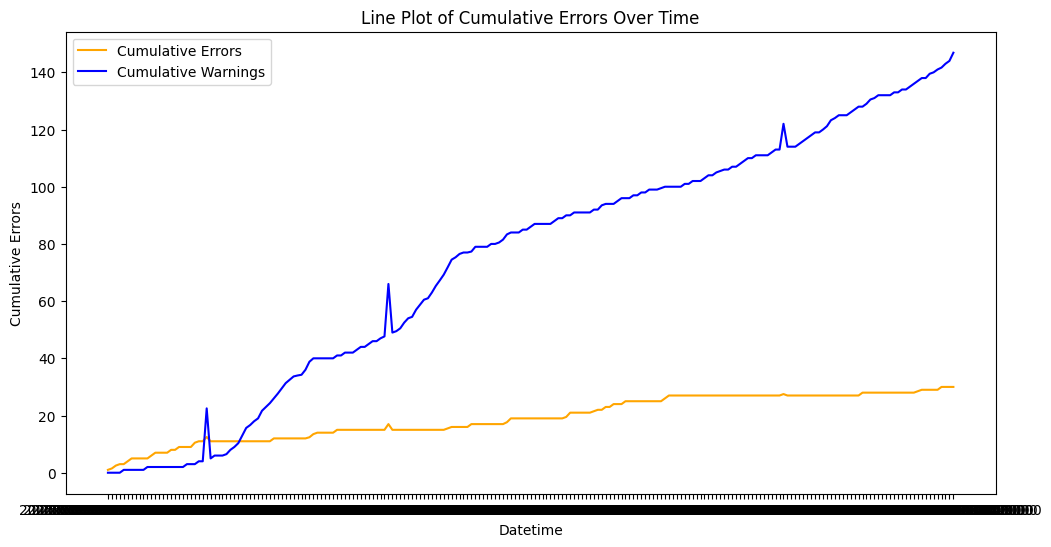

In [90]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=full_df, x='MerDate', y='is_error_cumulative', label='Cumulative Errors', color='orange', ci=None)
sns.lineplot(data=full_df, x='MerDate', y='is_warning_cumulative', label='Cumulative Warnings', color='blue', ci=None)
# sns.lineplot(data=full_df, x='MerDate', y='stop', label='stop', color='red', ci=None)

# Add vertical lines for stops
stop_dates = full_df[full_df['stop'] > 100]['MerDate']
for stop_date in stop_dates:
    plt.axvline(pd.to_datetime(stop_date), color='green', linestyle='--', alpha=0.7, label='Stop')

plt.title('Line Plot of Cumulative Errors Over Time')
plt.xlabel('Datetime')
plt.ylabel('Cumulative Errors')
plt.legend()
plt.show()

# We need to see the active warnings

How to make this in the code?

## I actually want to see the following information:
- time info on the x-axis
- number of active warnings/errors
- which lane
- stop

In [9]:
df = test.copy()
df = df[(df['index'] > 2000) & (df['index'] < 3000)]

In [288]:
df[df['MerType'] == 8 ]

,index,MerDate,MerId,MerType,MerNumber,MerSubNumber,MerData1,MerData2,MerData3,MerData4,MerData5,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority,Error/warnings,lane_stopping_machine,snapshot,time_delta
2058,2058,2025-01-30 11:13:01,11899369,8,0,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,8_0_0.0_0.0,NaN,22,0 days 00:04:23
2061,2061,2025-01-30 11:13:02,11899372,8,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,8_1_0.0_0.0,NaN,22,0 days 00:04:23
2140,2140,2025-01-30 11:17:26,11899461,8,0,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,8_0_0.0_0.0,NaN,23,0 days 00:00:07
2146,2146,2025-01-30 11:17:29,11899467,8,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,8_1_0.0_0.0,NaN,23,0 days 00:00:07
2150,2150,2025-01-30 11:17:35,11899472,8,0,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,8_0_0.0_0.0,NaN,24,0 days 00:00:06
2152,2152,2025-01-30 11:17:37,11899474,8,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,8_1_0.0_0.0,NaN,24,0 days 00:00:06
2161,2161,2025-01-30 11:17:44,11899483,8,0,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,8_0_0.0_0.0,NaN,25,0 days 00:00:10
2165,2165,2025-01-30 11:17:46,11899487,8,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,8_1_0.0_0.0,NaN,25,0 days 00:00:10
2177,2177,2025-01-30 11:17:55,11899499,8,0,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,8_0_0.0_0.0,NaN,26,0 days 00:00:11
2183,2183,2025-01-30 11:17:58,11899505,8,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,8_1_0.0_0.0,NaN,26,0 days 00:00:11


In [10]:
df['stop'] = df.apply(lambda row: row['MerNumber'] if row['MerType'] == 8 and row['MerSubNumber'] == 2 else 1, axis=1)

In [290]:
df[df['stop'] == 0]

,index,MerDate,MerId,MerType,MerNumber,MerSubNumber,MerData1,MerData2,MerData3,MerData4,...,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority,Error/warnings,lane_stopping_machine,snapshot,time_delta,stop
2058,2058,2025-01-30 11:13:01,11899369,8,0,2,0.0,0.0,0.0,NaN,...,4620,NaN,0,0,0,8_0_0.0_0.0,NaN,22,0 days 00:04:23,0
2140,2140,2025-01-30 11:17:26,11899461,8,0,2,0.0,0.0,0.0,NaN,...,4620,NaN,0,0,0,8_0_0.0_0.0,NaN,23,0 days 00:00:07,0
2150,2150,2025-01-30 11:17:35,11899472,8,0,2,0.0,0.0,0.0,NaN,...,4620,NaN,0,0,0,8_0_0.0_0.0,NaN,24,0 days 00:00:06,0
2161,2161,2025-01-30 11:17:44,11899483,8,0,2,0.0,0.0,0.0,NaN,...,4620,NaN,0,0,0,8_0_0.0_0.0,NaN,25,0 days 00:00:10,0
2177,2177,2025-01-30 11:17:55,11899499,8,0,2,0.0,0.0,0.0,NaN,...,4620,NaN,0,0,0,8_0_0.0_0.0,NaN,26,0 days 00:00:11,0
2201,2201,2025-01-30 11:18:07,11899523,8,0,2,0.0,0.0,0.0,NaN,...,4620,NaN,0,0,0,8_0_0.0_0.0,NaN,27,0 days 00:00:59,0
2251,2251,2025-01-30 11:19:07,11899574,8,0,2,0.0,0.0,0.0,NaN,...,4620,NaN,0,0,0,8_0_0.0_0.0,NaN,28,0 days 00:07:52,0
2553,2553,2025-01-30 11:27:03,11899890,8,0,3,0.0,0.0,0.0,NaN,...,4620,NaN,0,0,0,8_0_0.0_0.0,NaN,29,0 days 00:01:31,0
2628,2628,2025-01-30 11:28:35,11899967,8,0,2,0.0,0.0,0.0,NaN,...,4620,NaN,0,0,0,8_0_0.0_0.0,NaN,30,0 days 00:01:19,0
2734,2734,2025-01-30 11:29:56,11900074,8,0,1,0.0,0.0,0.0,NaN,...,4620,NaN,0,0,0,8_0_0.0_0.0,NaN,31,0 days 00:07:33,0


In [11]:
import pandas as pd

# Create a match key
df['match_key'] = list(zip(df['MerNumber'], df['MerSubNumber']))

# Initialize the unresolved column
df['unresolved_warn'] = pd.NA
df['unresolved_err'] = pd.NA


# Separate warnings and resolutions
warnings = df[df['MerType'].isin([22])].copy()
errors = df[df['MerType'].isin([21])].copy()
resolutions = df[df['MerType'].isin([23, 24])].copy()

# Track used resolutions
used_resolutions = set()

# Match warnings with resolutions
for idx, warn in warnings.iterrows():
    match = resolutions[
        (resolutions['match_key'] == warn['match_key']) &
        (resolutions['MerDate'] > warn['MerDate']) &
        (~resolutions.index.isin(used_resolutions))
    ]
    if not match.empty:
        res_idx = match.index[0]
        used_resolutions.add(res_idx)
        df.at[idx, 'unresolved_warn'] = 0
    else:
        df.at[idx, 'unresolved_warn'] = 1

# Match warnings with resolutions
for idx, err in errors.iterrows():
    match = resolutions[
        (resolutions['match_key'] == err['match_key']) &
        (resolutions['MerDate'] > err['MerDate']) &
        (~resolutions.index.isin(used_resolutions))
    ]
    if not match.empty:
        res_idx = match.index[0]
        used_resolutions.add(res_idx)
        df.at[idx, 'unresolved_err'] = 0
    else:
        df.at[idx, 'unresolved_err'] = 1

# Display the updated DataFrame
display(df)

,index,MerDate,MerId,MerType,MerNumber,MerSubNumber,MerData1,MerData2,MerData3,MerData4,...,MerDeviceNumber,MerPriority,Error/warnings,lane_stopping_machine,snapshot,time_delta,stop,match_key,unresolved_warn,unresolved_err
2001,2001,2025-01-30 11:11:42,11899305,23,414,5,0.0,0.0,0.0,NaN,...,0,0,23_414_0.0_0.0,5.0,21,0 days 00:03:36,1,"(414, 5)",<NA>,<NA>
2002,2002,2025-01-30 11:11:42,11899306,23,458,4,0.0,0.0,0.0,NaN,...,0,0,23_458_0.0_0.0,4.0,21,0 days 00:03:36,1,"(458, 4)",<NA>,<NA>
2003,2003,2025-01-30 11:11:45,11899307,23,411,5,0.0,0.0,0.0,NaN,...,0,0,23_411_0.0_0.0,5.0,21,0 days 00:03:36,1,"(411, 5)",<NA>,<NA>
2004,2004,2025-01-30 11:11:45,11899308,23,420,5,0.0,0.0,0.0,NaN,...,0,0,23_420_0.0_0.0,5.0,21,0 days 00:03:36,1,"(420, 5)",<NA>,<NA>
2005,2005,2025-01-30 11:11:46,11899309,23,460,12,0.0,0.0,0.0,NaN,...,0,0,23_460_0.0_0.0,12.0,21,0 days 00:03:36,1,"(460, 12)",<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,2025-01-30 11:38:07,11900356,23,98,4,0.0,0.0,0.0,NaN,...,0,0,23_98_0.0_0.0,NaN,32,0 days 00:00:34,1,"(98, 4)",<NA>,<NA>
2996,2996,2025-01-30 11:38:08,11900357,8,0,3,0.0,0.0,0.0,NaN,...,0,0,8_0_0.0_0.0,NaN,33,0 days 00:01:25,1,"(0, 3)",<NA>,<NA>
2997,2997,2025-01-30 11:38:20,11900359,21,430,10,0.0,13.0,0.0,NaN,...,0,0,21_430_13.0_0.0,10.0,33,0 days 00:01:25,1,"(430, 10)",<NA>,1
2998,2998,2025-01-30 11:38:20,11900360,22,490,12,0.0,11.0,0.0,NaN,...,0,0,22_490_11.0_0.0,12.0,33,0 days 00:01:25,1,"(490, 12)",1,<NA>


In [12]:
df['stop'].value_counts()

stop
1    990
0      9
Name: count, dtype: int64

In [293]:
# import pandas as pd

# df = active_errors
# # Create a match key
# df['match_key'] = list(zip(df['MerNumber'], df['MerSubNumber']))

# # Initialize the resolved column
# df['unresolved'] = pd.NA

# warnings = df[df['MerType'] == 22].copy()
# resolutions = df[df['MerType'] == 23].copy()

# used_resolutions = set()
# for idx, warn in warnings.iterrows():
#     match = resolutions[
#         (resolutions['match_key'] == warn['match_key']) &
#         (resolutions['MerDate'] > warn['MerDate']) &
#         (~resolutions.index.isin(used_resolutions))
#     ]
#     if not match.empty:
#         res_idx = match.index[0]
#         used_resolutions.add(res_idx)
#         df.at[idx, 'unresolved'] = 0
#     else:
#         df.at[idx, 'unresolved'] = 1

# display(df)


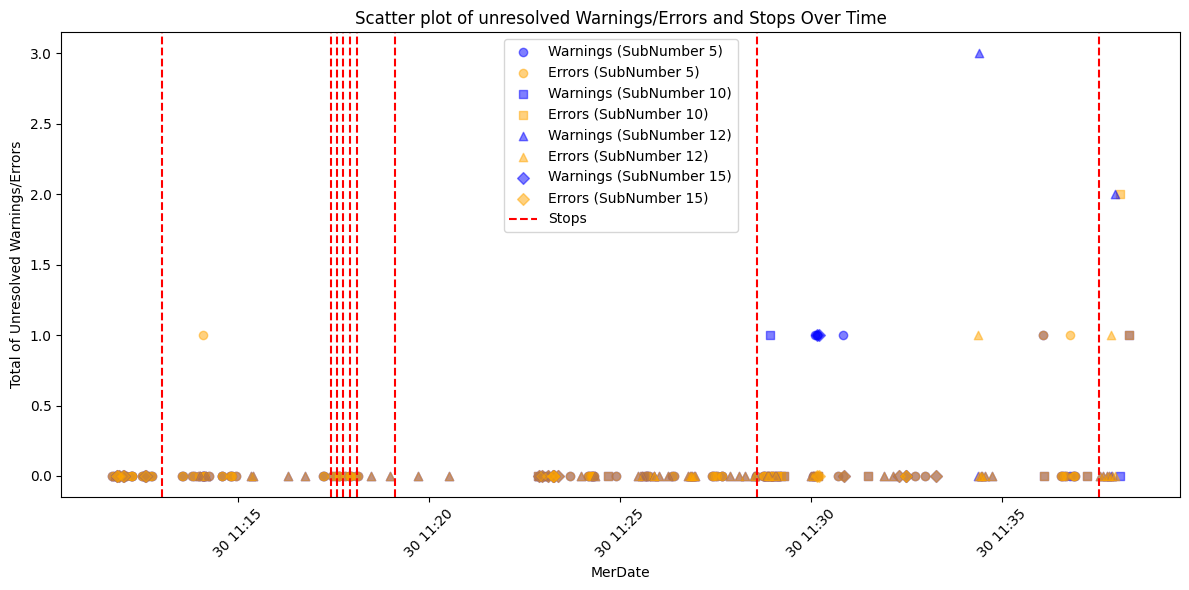

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Define a mapping of MerSubNumber to marker shapes
marker_shapes = {5: 'o', 10: 's', 12: '^', 15: 'D'}  # Add more mappings as needed

# Group data by MerDate and count unresolved warnings
scatter_data = df.groupby('MerDate').agg({
    'unresolved_warn': 'sum',
    'unresolved_err': 'sum',
    'MerSubNumber': 'first'  # Assuming MerSubNumber is consistent within each MerDate
}).reset_index()

# Convert MerDate to datetime for proper plotting
scatter_data['MerDate'] = pd.to_datetime(scatter_data['MerDate'])

# Create scatter plot
plt.figure(figsize=(12, 6))
for sub_number, marker in marker_shapes.items():
    subset = scatter_data[scatter_data['MerSubNumber'] == sub_number]
    plt.scatter(subset['MerDate'], subset['unresolved_warn'], label=f'Warnings (SubNumber {sub_number})', color='blue', alpha=0.5, marker=marker)
    plt.scatter(subset['MerDate'], subset['unresolved_err'], label=f'Errors (SubNumber {sub_number})', color='orange', alpha=0.5, marker=marker)

# Highlight stops with vertical lines
stop_data = df[df['stop'] == 0]
for i, stop_date in enumerate(pd.to_datetime(stop_data['MerDate'])):
    plt.axvline(stop_date, color='red', linestyle='--', label='Stops' if i == 0 else "")

# Final plot formatting
plt.title('Scatter plot of unresolved Warnings/Errors and Stops Over Time')
plt.xlabel('MerDate')
plt.ylabel('Total of Unresolved Warnings/Errors')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# We want to see the number of active lanes vs the machine stops

- lanes on the y axis
- time on the x axis
- boxes of active time for every lane OR boxes of inactive lanes
- stops as vertical line

In [51]:
active_lanes = test.copy()
active_lanes = active_lanes[(active_lanes['index'] > 2000) & (active_lanes['index'] < 2500)]
active_lanes = active_lanes[(active_lanes['MerNumber'] > 400) | ((active_lanes['MerType'] == 8) & (active_lanes['MerNumber'] == 0) & (active_lanes['MerSubNumber'] == 2))]

In [55]:
active_lanes.describe()

,index,MerDate,MerId,MerType,MerNumber,MerSubNumber,MerData1,MerData2,MerData3,MerData4,...,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority,lane_stopping_machine,snapshot,Error,LaneNumber,Stop
count,304.000000,304,3.040000e+02,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,0.0,...,304.0,0.0,304.0,304.0,304.0,297.000000,304.000000,304.000000,304.000000,304.000000
mean,2233.062500,2025-01-30 11:19:10,1.189956e+07,21.868421,432.230263,10.750000,0.151316,4.838816,1.756579,NaN,...,4620.0,NaN,0.0,0.0,0.0,10.956229,25.549342,0.483553,10.703947,0.023026
min,2001.000000,2025-01-30 11:11:42,1.189930e+07,8.000000,0.000000,2.000000,0.000000,0.000000,0.000000,NaN,...,4620.0,NaN,0.0,0.0,0.0,3.000000,21.000000,0.000000,0.000000,0.000000
25%,2091.750000,2025-01-30 11:14:42,1.189940e+07,21.000000,414.000000,5.000000,0.000000,0.000000,0.000000,NaN,...,4620.0,NaN,0.0,0.0,0.0,5.000000,22.000000,0.000000,5.000000,0.000000
50%,2251.500000,2025-01-30 11:19:07,1.189957e+07,22.000000,452.000000,12.000000,0.000000,0.000000,0.000000,NaN,...,4620.0,NaN,0.0,0.0,0.0,12.000000,28.000000,0.000000,12.000000,0.000000
75%,2352.250000,2025-01-30 11:23:17,1.189968e+07,23.000000,460.000000,15.000000,0.000000,11.000000,0.000000,NaN,...,4620.0,NaN,0.0,0.0,0.0,15.000000,28.000000,1.000000,15.000000,0.000000
max,2492.000000,2025-01-30 11:26:25,1.189983e+07,23.000000,490.000000,17.000000,4.000000,24.000000,41.000000,NaN,...,4620.0,NaN,0.0,0.0,0.0,17.000000,28.000000,1.000000,17.000000,1.000000
std,140.919889,NaN,1.503635e+02,2.304205,72.321748,5.028303,0.523505,5.999753,6.449598,NaN,...,0.0,NaN,0.0,0.0,0.0,4.901886,2.973624,0.500553,5.116902,0.150234


In [52]:
#create error column
active_lanes['Error'] = active_lanes['MerType'].apply(lambda x: 1 if x in [21, 22] else 0)

# create LaneNumber
active_lanes['LaneNumber'] = active_lanes.apply(lambda row: row['MerSubNumber'] if row['MerNumber'] >= 400 else None, axis=1)
active_lanes['LaneNumber'] = active_lanes['LaneNumber'].fillna(0).astype(int)

# create machine stop column
active_lanes['Stop'] = active_lanes.apply(lambda row: 1 if row['MerType'] == 8 and row['MerNumber'] == 0 and row['MerSubNumber'] == 2 else 0, axis=1)


# cast MerDate to datetime
active_lanes['MerDate'] = active_lanes['MerDate'].astype('datetime64[s]')

In [53]:
active_lanes.head()

,index,MerDate,MerId,MerType,MerNumber,MerSubNumber,MerData1,MerData2,MerData3,MerData4,...,MerDeviceType,MerDeviceNumber,MerPriority,Error/warnings,lane_stopping_machine,snapshot,time_delta,Error,LaneNumber,Stop
2001,2001,2025-01-30 11:11:42,11899305,23,414,5,0.0,0.0,0.0,NaN,...,0,0,0,23_414_0.0_0.0,5.0,21,0 days 00:03:36,0,5,0
2002,2002,2025-01-30 11:11:42,11899306,23,458,4,0.0,0.0,0.0,NaN,...,0,0,0,23_458_0.0_0.0,4.0,21,0 days 00:03:36,0,4,0
2003,2003,2025-01-30 11:11:45,11899307,23,411,5,0.0,0.0,0.0,NaN,...,0,0,0,23_411_0.0_0.0,5.0,21,0 days 00:03:36,0,5,0
2004,2004,2025-01-30 11:11:45,11899308,23,420,5,0.0,0.0,0.0,NaN,...,0,0,0,23_420_0.0_0.0,5.0,21,0 days 00:03:36,0,5,0
2005,2005,2025-01-30 11:11:46,11899309,23,460,12,0.0,0.0,0.0,NaN,...,0,0,0,23_460_0.0_0.0,12.0,21,0 days 00:03:36,0,12,0


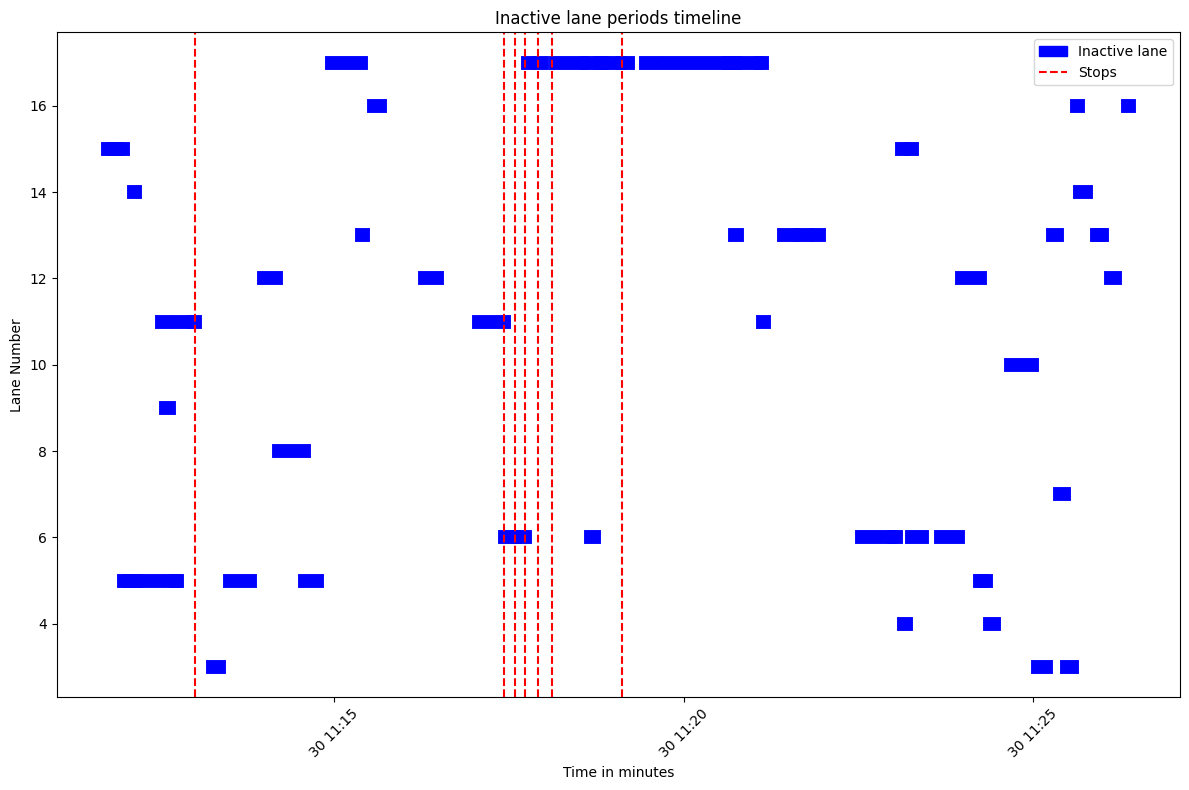

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

def plot_lanes(df):
    # Identify error periods
    start_time = None
    boxes = []

    for index, row in df.iterrows():
        if row['Error'] == 1 and start_time is None:
            start_time = row['MerDate']
            lane = row['LaneNumber']
        elif row['Error'] == 0 and start_time is not None:
            boxes.append((start_time, row['MerDate'], lane))
            start_time = None

    # Handle case where error continues till the end
    if start_time is not None:
        boxes.append((start_time, df['MerDate'].iloc[-1], lane))

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))

    for start, end, lane in boxes:
        ax.plot([start, end], [lane, lane], color='blue', linewidth=10)

    # Highlight stops with vertical lines
    stop_data = df[df['Stop'] == 1]
    for i, stop_date in enumerate(pd.to_datetime(stop_data['MerDate'])):
        ax.axvline(stop_date, color='red', linestyle='--', label='Stops' if i == 0 else "")

    # Add proxy artist for error periods to legend
    error_patch = mpatches.Patch(color='blue', label='Inactive lane')

    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xlabel('Time in minutes')
    ax.set_ylabel('Lane Number')
    ax.set_title('Inactive lane periods timeline')
    ax.legend(handles=[error_patch] + ax.get_legend_handles_labels()[0])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_lanes(active_lanes)
